# Part 1: Import Libraries, Data, and Helper Functions



In [ ]:
# Import libraries
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

# Import data
uploaded = files.upload()

Saving sequence_fasta.txt to sequence_fasta.txt


In [ ]:
# Define Base indices
D = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
ID = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}

In [ ]:
# Transition and Emission Matrix
T = np.array([[0.9999, 0.0001], [0.01, 0.99]])
E = np.array([[0.25, 0.25, 0.25, 0.25], [0.20, 0.30, 0.30, 0.20]])

In [ ]:
# Process the data
def getData():
  # Open and parse the data
  with open('sequence_fasta.txt') as f:
    lines = f.readlines()

  # Remove trailing '\n'
  lines = list(map(str.strip, lines))

  # Join the string
  data = ''.join(lines)

  # Remove unknown bases
  # data = clean(data)
  
  return data

In [ ]:
# Replace all unknown bases to 'T' as suggested
def clean(data):
  res = ''
  ptr = 0
  for i in range(0, len(data)):
    if (data[i] not in D):
      if (i > 0):
        res += (data[ptr : i] + 'T')
        ptr = i + 1
  if (ptr < len(data)):
    res += data[ptr:]
  return res

In [ ]:
# Return the count of dinucleotides in given sequence
def getCount(d):
  count = dict()
  for i in range(0, len(d) - 1):
    if str(d[i : i + 2]) not in count:
      count[str(d[i : i + 2])] = 0
    else:  
      count[str(d[i : i + 2])] += 1
  return count

In [ ]:
# Return a markov model of given data
def getModel(df):
  F = np.zeros((4, 4))
  for k in df:
    F[D[k[1]], D[k[0]]] = df[k]
  return F / F.sum(axis = 0)

In [ ]:
# Get data
data = getData()

In [ ]:
def log_sum(x, y):
  if np.isnan(x) or np.isnan(x):
    return np.nan
  if (x > y):
    return x + np.log(1 + np.exp(y - x))
  else:
    return y + np.log(1 + np.exp(x - y))

# Part 2: Implement Viterbi Algorithm

*For simplicity, state are 0-based where state 1 -> state 0 and state 2 -> state 1*

In [ ]:
# Return most probable hidden state sequence
def viterbi(data):
  N = len(data)               # Length of sequence
  K = 2                       # Number of States 
  V = np.zeros((K, N + 1))    # Joint Probability Tensor
  P = np.zeros((K, N + 1))    # Pointer Tensor
  V.fill(-float('inf'))
  P.fill(-float('inf'))

  # Initialize start state = State 0
  V[:, 0] = np.log(T[0])

  # Iterative Dynamic Programming
  for i in range(1, N + 1):
    for j in range(0, K):
      for k in range(0, K):
        p = V[k, i - 1] + np.log(T[k, j] * E[j, D[data[i - 1]]])
        if (p > V[j][i]):
          V[j, i] = p
          P[j, i] = k
  
  # # Find the max sequence end
  m = 1 if V[1, N] > V[0, N] else 0
  res = np.zeros((N,), dtype = int)
  res[N - 1] = m

  # Backtrace the sequence
  for i in range(N - 2, -1, -1):
    res[i] = P[res[i + 1], i + 1]
  return res

In [ ]:
# Find all chains of state 2 from given data
def getChains(data):
  chains = []
  state = 0
  start = 0
  for i in range(data.size):
    if data[i] == 0:
      if (state):
        chains += [(start, i - start)]
        state = 0
        start = 0
    else:
      if (state == 0):
        state = 1
        start = i
  return chains

In [ ]:
# Find the longest chain from given chains
def getLongestChain(data):
  data = getChains(data)
  mx = 0
  start = 0
  for i in range(len(data)):
    if data[i][1] > mx:
      mx = data[i][1]
      start = data[i][0]
  return (start, mx)

In [ ]:
# Plot the data
def plotData(res):
  fig, axs = plt.subplots(6, figsize = (20, 20))
  fig.suptitle('Most Probable Hidden State')
  S = 300000
  for i in range(6):
    mx = min((i + 1) * S, res.size)
    axs[i].plot(range(i * S, mx), res[i * S : mx] + 1)

In [ ]:
# Run Viterbi
res = viterbi(data)

In [ ]:
# Find the longest state 2 chain (start, len)
longest_chain = getLongestChain(res)
print(longest_chain)

(638464, 4984)


In [ ]:
# Find the longest state 2 sequence
longest_seq = data[longest_chain[0] : longest_chain[0] + longest_chain[1]]

In [ ]:
getModel(getCount(longest_seq))

array([[0.30934579, 0.16534296, 0.18113859, 0.25355757],
       [0.21682243, 0.39061372, 0.24036803, 0.24967658],
       [0.33551402, 0.28808664, 0.41403105, 0.33764554],
       [0.13831776, 0.15595668, 0.16446233, 0.15912031]])

In [ ]:
getModel(getCount(data))

array([[0.38953307, 0.35554396, 0.36263508, 0.28532515],
       [0.11261281, 0.21396814, 0.17541738, 0.16246905],
       [0.17546846, 0.0504098 , 0.21992373, 0.16316587],
       [0.32238567, 0.38007809, 0.24202382, 0.38903992]])

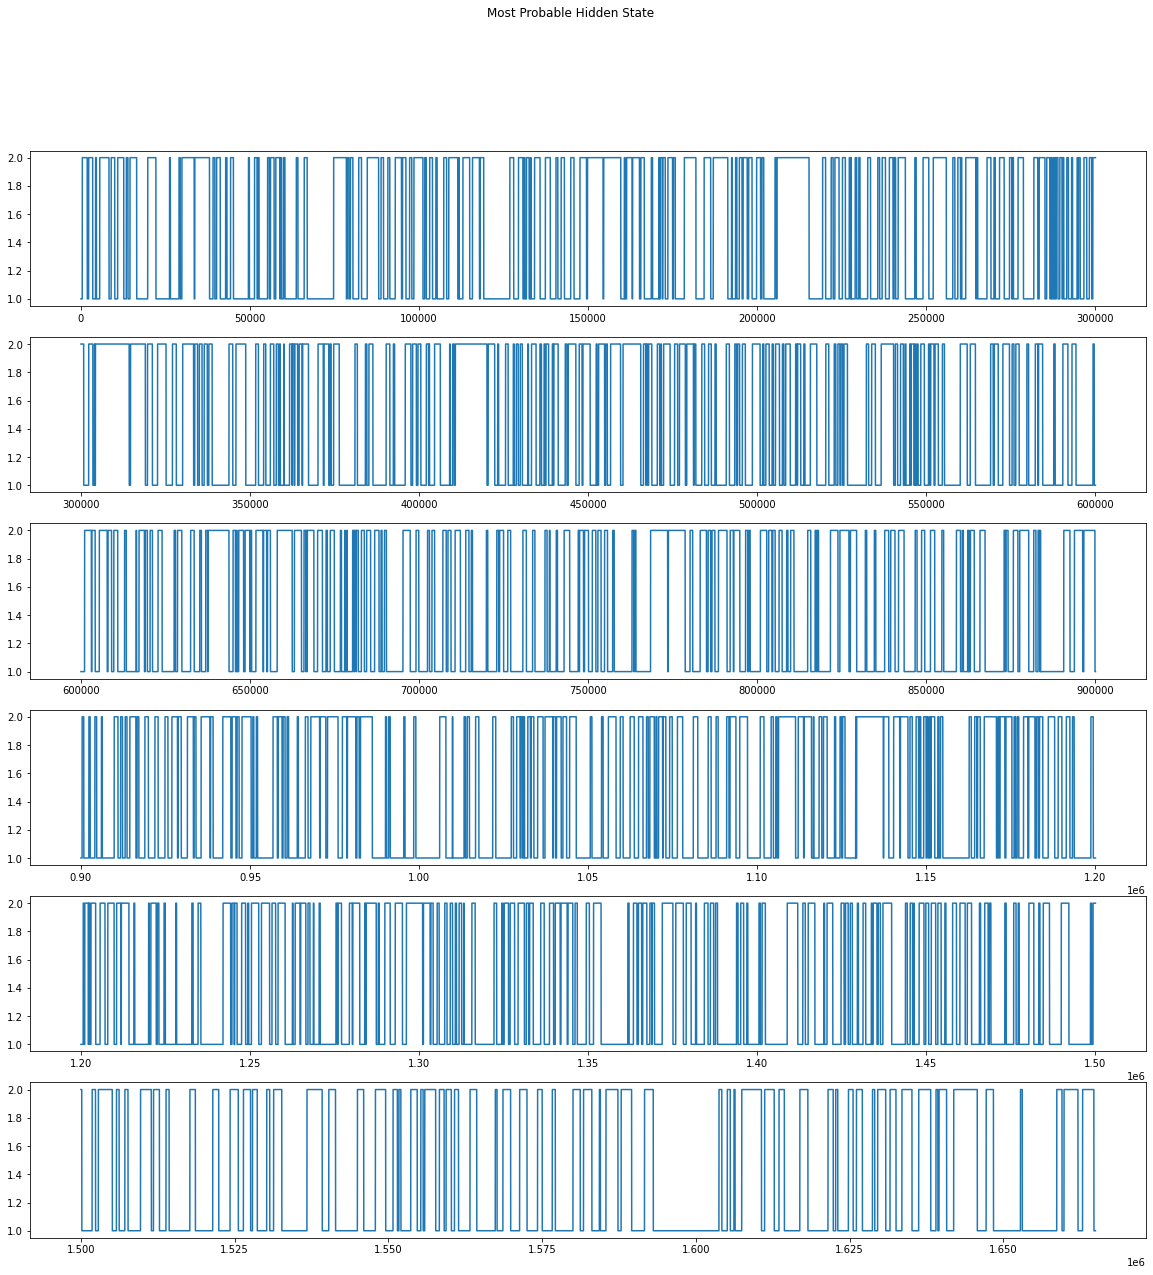

In [ ]:
# Plot the states
plotData(res)

# part 3: Implement Baum Welch Algorithm

In [ ]:
a = np.array([[0.9999, 0.0001], [0.01, 0.99]])
b = np.array([[0.25, 0.25, 0.25, 0.25], [0.20, 0.30, 0.30, 0.20]])
init = np.array([[0.99, 0.01]])

In [ ]:
# Forward algorithm
# Arguments: data, transition matrix (a), emission matrix (b), initial distribution
# Return the forward probability
def forward(data, a, b, init):
  N = len(data)               # Length of sequence
  K = a.shape[0]              # Number of States = 2
  V = np.zeros((N, K))        # Joint Probability Matrix

  # Initialize start state = State 0
  V[0] = init * b[:, D[data[0]]]
  V[0] /= np.sum(V[0])

  for i in range(1, N):
    V[i] = (a.T).dot(V[i - 1]) * (b[:, D[data[i]]])

    # Non-vectorized code
    # for j in range(K):
    #   V[i, j] = V[i - 1].dot(a[:, j]) * b[j, D[data[i]]]

    # Normalize
    V[i] /= np.sum(V[i])

  return V

In [ ]:
# Backward algorithm
# Arguments: data, transition matrix (a), emission matrix (b)
# Return the backward probability
def backward(data, a, b):
  N = len(data)               # Length of sequence
  K = a.shape[0]              # Number of States 
  V = np.zeros((N, K))        # Joint Probability Matrix

  # Initialize end state
  V[N - 1] = np.ones((K)) / K

  for i in range(N - 2, -1, -1):
    V[i] = (V[i + 1] * b[:, D[data[i + 1]]]).dot(a.T)

    # Non-vectorized code
    # for j in range(K):
    #   V[i, j] = (V[i + 1] * b[:, D[data[i + 1]]]).dot(a[j, :])

    # Normalize
    V[i] /= np.sum(V[i])
  return V

In [ ]:
subset = data[0:1000]

In [ ]:
forward(subset, a, b, init)

array([[9.91983968e-01, 8.01603206e-03],
       [9.93561597e-01, 6.43840272e-03],
       [9.92241994e-01, 7.75800572e-03],
       ...,
       [9.99333319e-01, 6.66680904e-04],
       [9.99391950e-01, 6.08050359e-04],
       [9.99438394e-01, 5.61606079e-04]])

In [ ]:
backward(subset, a, b)

array([[0.92529193, 0.07470807],
       [0.9180134 , 0.0819866 ],
       [0.93742566, 0.06257434],
       ...,
       [0.60782151, 0.39217849],
       [0.55493402, 0.44506598],
       [0.5       , 0.5       ]])

In [ ]:
def baum_welch(data, a, b, init, n):
  N = len(data)               # Length of sequence
  K = a.shape[0]              # Number of States 

  for i in range(n):
    # Log
    print("Iteration " + str(i))

    fd = forward(data, a, b, init)
    bd = backward(data, a, b)

    # Compute Xi
    Xi = np.zeros((K, K, N - 1))

    for t in range(N - 1):
      denominator = np.dot(np.dot(fd[t, :].T, a) * b[:, D[data[t + 1]]].T, bd[t + 1, :])
      for i in range(K):
        numerator = fd[t, i] * a[i, :] * b[:, D[data[t + 1]]].T * bd[t + 1, :].T
        Xi[i, :, t] = numerator / denominator

    # Compute Gamma
    Gamma = np.sum(Xi, axis = 1)
    a = np.sum(Xi, 2) / np.sum(Gamma, axis = 1).reshape((-1, 1))

    # Add additional N'th element in gamma
    Gamma = np.hstack((Gamma, np.sum(Xi[:, :, N - 2], axis = 0).reshape((-1, 1))))
 
    denominator = np.sum(Gamma, axis=1)
    b[:] = 0
    for j in range(N):
      b[:, D[data[j]]] += Gamma[:, j]
 
    b = np.divide(b, denominator.reshape((-1, 1)))

  print("Result after " + str(n) + " iterations")
  print("a: \n" + str(a))
  print("b: \n" + str(b))

In [ ]:
test = baum_welch(data, a.copy(), b.copy(), init, 50)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Result after 50 iterations
a: 
[[9.99915349e-01 8.46511330e-05]
 [6.65695097e-03 9.93343049e-01]]
b: 
[[0.34622403 0.15354194 0.15704052 0.34319352]
 [0.20159513 0.29810691 0.30557406 0.1947239 ]]


**Result after 50 iterations (58 minutes)**

a: 
[[9.99915349e-01 8.46511330e-05]
 [6.65695097e-03 9.93343049e-01]]

b: 
[[0.34622403 0.15354194 0.15704052 0.34319352]
 [0.20159513 0.29810691 0.30557406 0.1947239 ]]

# Final Project

In [ ]:
data = getData()

In [ ]:
getCount(data)

{'AA': 335567,
 'AC': 187215,
 'AG': 253503,
 'AT': 268337,
 'CA': 274904,
 'CC': 212374,
 'CG': 55766,
 'CN': 21,
 'CT': 267783,
 'GA': 222245,
 'GC': 172025,
 'GG': 204666,
 'GN': 0,
 'GT': 194758,
 'NA': 0,
 'NC': 1,
 'NG': 21,
 'NN': 6309975,
 'TA': 211906,
 'TC': 239233,
 'TG': 279738,
 'TN': 0,
 'TT': 361773}

In [ ]:
def checkNull(d):
  start = -1
  for i in range(0, len(d) - 1):
    if (d[i] != 'N'):
      if (start == -1):
        start = i
    else:
      if (start != -1):
        print(str(start) + " " + str(i - 1))
        start = -1

In [ ]:
checkNull(data)

5010000 5166245
5216246 5393557
5443558 5449011
5499012 5627595
5677596 5796008
5846009 5916592
5966593 6161370
6211371 6377257
6427258 6580180
6630181 6739084
6789085 6934218
6984219 7149526
7199527 7327864
7377865 7500889
7550890 7693699
7743700 7865745
7915746 8049838
8099839 8217205
8217207 8260970
8310971 8472359
8522360 8706714
8756715 8886603
8986604 9196086
9246087 9377142
